In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from calibrate import *

In [2]:
Temps = pd.read_hdf('calibration/Days14_15.hdf5')
log_Temps = np.log10(Temps)

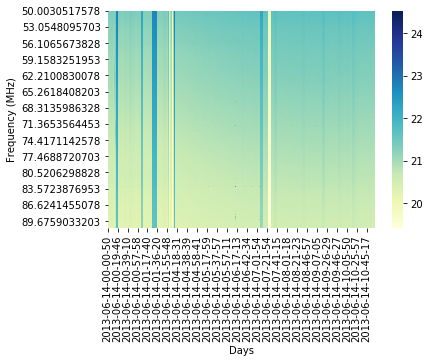

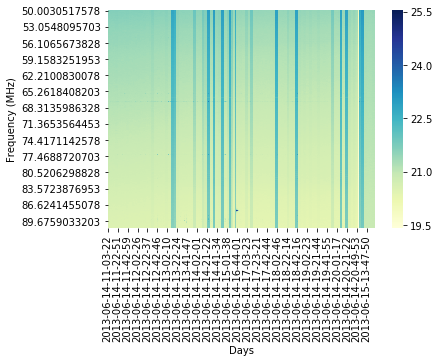

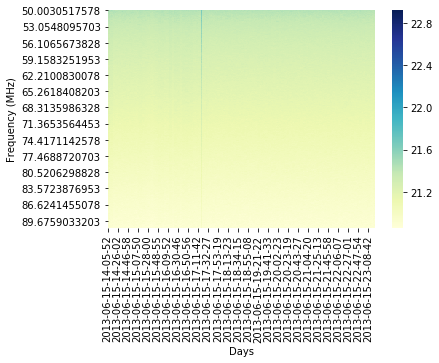

In [3]:
cols = Temps.columns.values
sb.heatmap(log_Temps[cols[0:2500]], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frequency (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%(cols[0],cols[2500]))
plt.show()

sb.heatmap(log_Temps[cols[2500:5000]], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frequency (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%(cols[2500],cols[5000]))
plt.show()

sb.heatmap(log_Temps[cols[5000:]], cmap='YlGnBu', yticklabels=400)
plt.xlabel('Days')
plt.ylabel('Frequency (MHz)')
plt.savefig('Imagenes/Data_%s_%s.png'%(cols[5000],cols[-1]))
plt.show()

# Check data quality

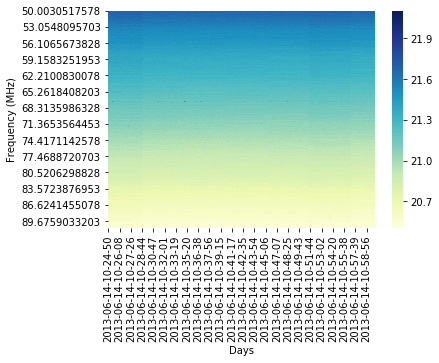

In [4]:
path = 'calibration/Days14_15.hdf5'
dates = ['2013-06-14-10-24-50','2013-06-14-10-59-52']
impath = '/home/hiram/Documentos/Tesis/Tesis_latex/Imagenes/'
Check_quality(path,dates,savepath = impath)

# Selecting Dates

In [5]:
paths = 'calibration/Days14_15.hdf5'
paths_jnc = ('calibration/Days14_15_93dBm.hdf5','calibration/Kjnc_Days14_15_93dBm.hdf5')
dates = ['2013-06-14-10-24-50','2013-06-14-10-59-52','2013-06-14 17:30:00.000','2013-06-14 18:00:00.000']

$\chi^2$

In [6]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)

In [7]:
freqs = np.arange(50,91)

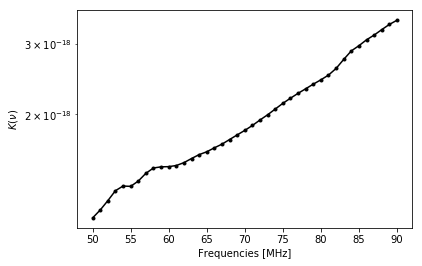

In [8]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu.png')

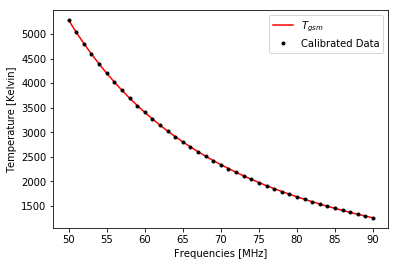

In [9]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated.png')

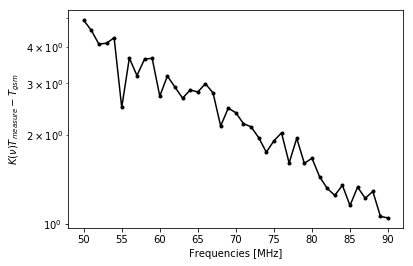

In [10]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm.png')

JNC

In [11]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')

In [12]:
freqs = np.arange(50,91)

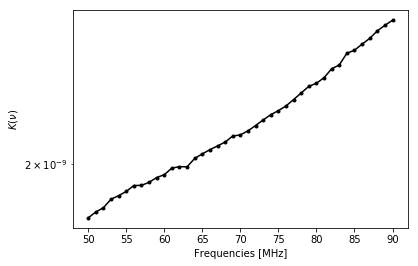

In [13]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu_jnc.png')

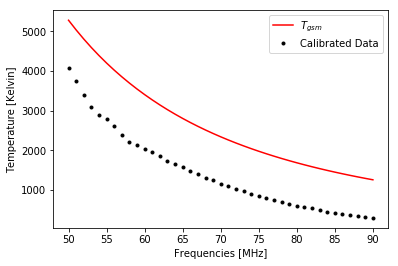

In [14]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_jnc.png')

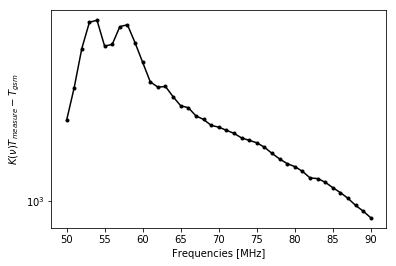

In [15]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_jnc.png')

# Dates second try

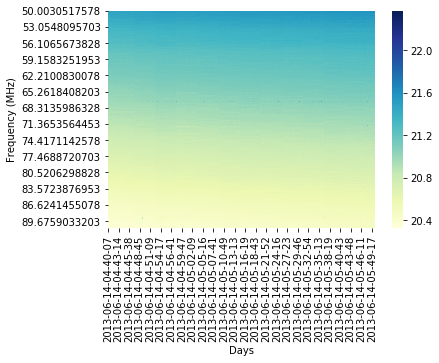

In [16]:
# Quality check
dates = ['2013-06-14-04-40-07','2013-06-14-05-50-01']
Check_quality(path,dates,savepath = impath)

In [17]:
dates = ['2013-06-14-04-40-07','2013-06-14-05-50-01','2013-06-14 11:45:00.000','2013-06-14 12:50:00.000']

$\chi^2$

In [18]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)

In [19]:
freqs = np.arange(50,91)

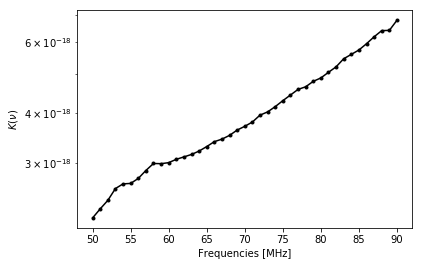

In [20]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu_2.png')

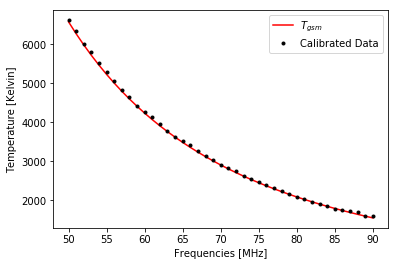

In [21]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_2.png')

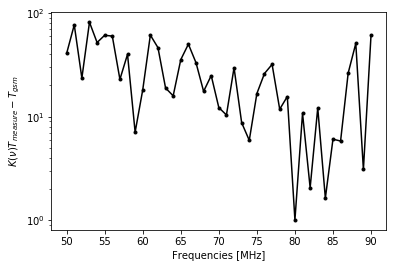

In [22]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_2.png')

JNC

In [23]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')

In [24]:
freqs = np.arange(50,91)

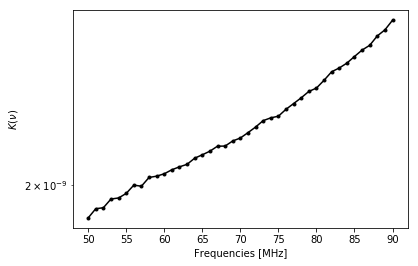

In [25]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu_jnc_2.png')

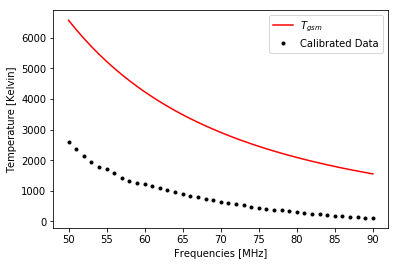

In [26]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_jnc_2.png')

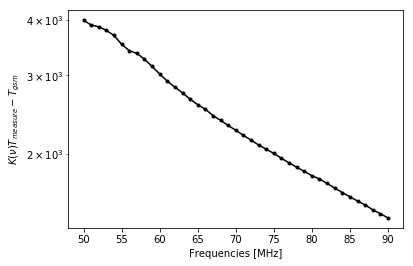

In [27]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_jnc_2.png')

# More dates...

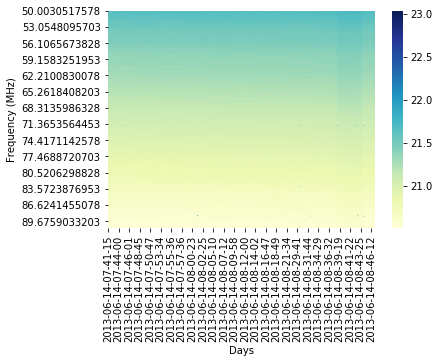

In [28]:
# Quality check
dates = ['2013-06-14-07-41-15','2013-06-14-08-46-57']
Check_quality(path,dates,savepath = impath)

In [41]:
dates = ['2013-06-14-07-41-15','2013-06-14-08-46-57','2013-06-14 00:40:00.000','2013-06-14 01:40:00.000']

$\chi^2$

In [42]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths,dates)

In [43]:
freqs = np.arange(50,91)

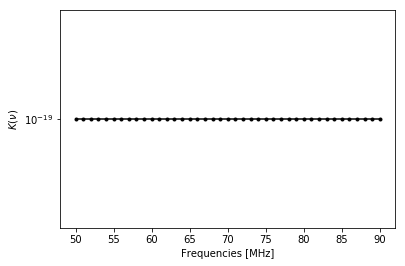

In [44]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu_2.png')

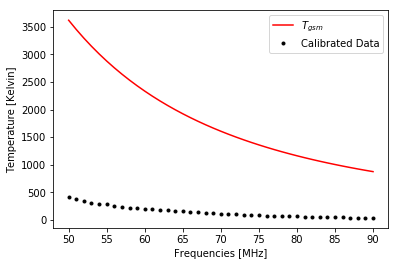

In [45]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_2.png')

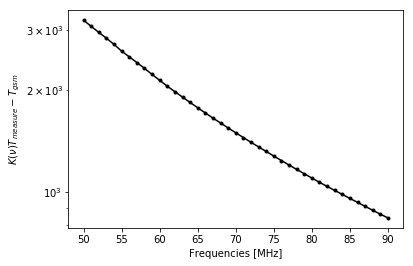

In [46]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_2.png')

JNC

In [47]:
K_nu,Tgsm,Tmeas,Tstd = Calibrate(paths_jnc,dates,calibration='JNC')

In [48]:
freqs = np.arange(50,91)

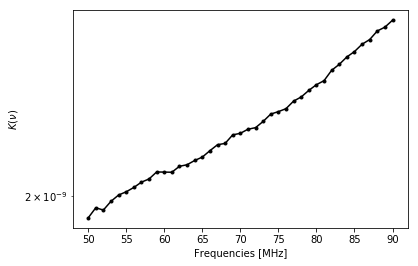

In [49]:
plt.semilogy(freqs,K_nu,'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)$')
plt.savefig(impath+'K_nu_jnc_2.png')

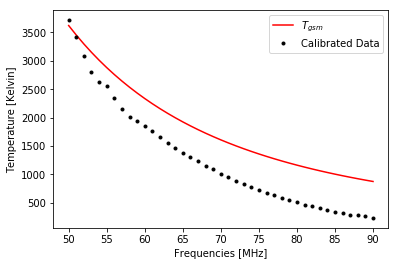

In [50]:
plt.plot(freqs,Tgsm, 'r',label=r'$T_{gsm}$')
plt.plot(freqs,K_nu*Tmeas,'.k', label = 'Calibrated Data')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.legend()
plt.savefig(impath+'calibrated_jnc_2.png')

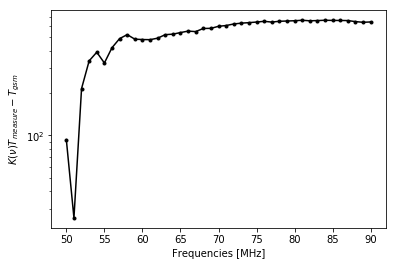

In [51]:
plt.semilogy(freqs,abs(K_nu*Tmeas - Tgsm),'.-k')
plt.xlabel('Frequencies [MHz]')
plt.ylabel(r'$K(\nu)T_{measure}-T_{gsm}$')
plt.savefig(impath+'KTmeas-Tgsm_jnc_2.png')